In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import timedelta

plt.rcParams['font.family'] = 'Malgun Gothic'  # or 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False




In [2]:
import numpy as np
from scipy.spatial import cKDTree
pd.set_option('display.max_columns', None)


## 산림 임상 데이터 불러오기

In [3]:
data = gpd.read_file("./modified_geopackage/merged100_converted(artif_included).gpkg")
data = data.to_crs(epsg = 4326)
data["centroids"] = data.geometry.centroid
data

C:\Users\sc.lee\AppData\Local\Temp\ipykernel_25856\2742152051.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data["centroids"] = data.geometry.centroid


,index,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,geometry,centroids
0,0,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92156 37.44277, 126.92144 ...",POINT (126.92202 37.44349)
1,1,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.91631 37.48976, 126.91672 ...",POINT (126.91649 37.4881)
2,2,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92213 37.49274, 126.92385 ...",POINT (126.9229 37.49214)
3,3,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.91117 37.45484, 126.91303 ...",POINT (126.91419 37.45243)
4,4,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.92227 37.45497, 126.92483 ...",POINT (126.92328 37.45185)
...,...,...,...,...,...,...,...,...
445510,501718,Q,2,4,C,활엽수림,"MULTIPOLYGON (((127.86824 35.99774, 127.87158 ...",POINT (127.86934 35.9955)
445511,501719,Q,2,5,B,활엽수림,"MULTIPOLYGON (((127.8648 35.99199, 127.8671 35...",POINT (127.86485 35.99106)
445512,501720,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.87263 35.98754, 127.87137 ...",POINT (127.8712 35.98653)
445513,501721,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.875 35.99708, 127.875 35.9...",POINT (127.87439 35.99678)


## 기상 관측 지점 데이터 불러오기

In [4]:
loc_df = pd.read_csv("./weather_observed/meta-loc-edited.csv", encoding='cp949')
loc_gdf = gpd.GeoDataFrame(
    loc_df, geometry=gpd.points_from_xy(loc_df.경도, loc_df.위도), crs="EPSG:4326"
)
loc_gdf.지점 = loc_gdf.지점.apply(str)

## 기상 관측 정보에 있는 지점들로 전처리 

In [5]:
# 기상 관측 정보 불러오기 
weather = gpd.read_file("./weather_observed/whetherDataEH.csv", encoding='cp949')

In [6]:
weather

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),실효습도
0,12,안면도(감),2022-01-01 00:00,-4.5,34.0,2.6,0.0,59.0,17.700000000000003
1,12,안면도(감),2022-01-01 01:00,-4.6,37.8,2.4,0.0,58.0,29.790000000000003
2,12,안면도(감),2022-01-01 02:00,-5.0,62.6,2.7,0.0,65.0,31.680000000000003
3,12,안면도(감),2022-01-01 03:00,-5.0,68.4,2.9,0.0,54.0,29.850000000000005
4,12,안면도(감),2022-01-01 04:00,-4.9,65.6,2.7,0.0,51.0,26.640000000000004
...,...,...,...,...,...,...,...,...,...
16418967,996,화동,2024-12-31 19:00,-0.5,268.2,3.1,0.0,38.0,18.960000000000004
16418968,996,화동,2024-12-31 20:00,-0.8,266.5,3.8,0.0,38.0,19.380000000000003
16418969,996,화동,2024-12-31 21:00,-1.6,262.5,5.2,0.0,46.0,21.78
16418970,996,화동,2024-12-31 22:00,-2.4,263.6,3.9,0.0,55.0,26.16


In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16418972 entries, 0 to 16418971
Data columns (total 9 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   지점       object
 1   지점명      object
 2   일시       object
 3   기온(°C)   object
 4   풍향(deg)  object
 5   풍속(m/s)  object
 6   강수량(mm)  object
 7   습도(%)    object
 8   실효습도     object
dtypes: object(9)
memory usage: 1.1+ GB


In [8]:
# 기상 관측 정보에 있는 지점들 찾기
loc_gdf_needed = loc_gdf[loc_gdf.지점.isin(weather.지점.unique())]
loc_gdf_needed

,지점,시작일,종료일,지점명,위도,경도,geometry
0,12,2007-11-30,NaN,안면도(감),36.5333,126.3167,POINT (126.3167 36.5333)
1,96,2020-10-23,NaN,독도,37.2395,131.8698,POINT (131.8698 37.2395)
2,116,2023-10-21,NaN,관악(레),37.4453,126.9640,POINT (126.964 37.4453)
4,160,2020-10-23,NaN,부산(레),35.1188,129.0000,POINT (129 35.1188)
5,175,2024-10-15,NaN,진도(레),34.4721,126.3238,POINT (126.3238 34.4721)
...,...,...,...,...,...,...,...
567,992,2021-11-10,NaN,하빈,35.9062,128.4464,POINT (128.4464 35.9062)
568,993,2024-04-06,NaN,제주금악,33.3423,126.3099,POINT (126.3099 33.3423)
569,994,2022-05-02,NaN,심포,35.8545,126.6421,POINT (126.6421 35.8545)
570,995,2023-12-19,NaN,오천,35.9286,129.3822,POINT (129.3822 35.9286)


In [9]:
loc_gdf

,지점,시작일,종료일,지점명,위도,경도,geometry
0,12,2007-11-30,NaN,안면도(감),36.5333,126.3167,POINT (126.3167 36.5333)
1,96,2020-10-23,NaN,독도,37.2395,131.8698,POINT (131.8698 37.2395)
2,116,2023-10-21,NaN,관악(레),37.4453,126.9640,POINT (126.964 37.4453)
3,144,1993-03-16,2011-12-09,군산(레),36.0123,126.7834,POINT (126.7834 36.0123)
4,160,2020-10-23,NaN,부산(레),35.1188,129.0000,POINT (129 35.1188)
...,...,...,...,...,...,...,...
567,992,2021-11-10,NaN,하빈,35.9062,128.4464,POINT (128.4464 35.9062)
568,993,2024-04-06,NaN,제주금악,33.3423,126.3099,POINT (126.3099 33.3423)
569,994,2022-05-02,NaN,심포,35.8545,126.6421,POINT (126.6421 35.8545)
570,995,2023-12-19,NaN,오천,35.9286,129.3822,POINT (129.3822 35.9286)


In [10]:
loc_array = loc_gdf['지점명'].unique()

# 관측 중단 후 시작된 지점 중복 데이터 제거됐는지 확인 (최신 관측소로 통일)

In [11]:
# 지점 정보에 있는 중복 "지점명" 없음 
for i in loc_gdf_needed.지점명[loc_gdf_needed.지점명.duplicated() == True]:
    print(loc_gdf_needed[loc_gdf_needed.지점명 == i])

# weather data에서 빼야 할 강북*, 백아, 강진면 발견 

In [12]:
# 강북*, 백아 위치 정보 필요 
for i in weather.지점명.unique():
    if i not in loc_gdf_needed.지점명.unique():
        print(i)

강북*
백아
강진면


# 행정구역 경계 정보 불러오기 

In [13]:
bdd = gpd.read_file(f"../data/ctprvn_20230729/ctprvn.shp", encoding="euc-kr")
bdd.set_crs(epsg=5179, inplace=True)
bdd = bdd.to_crs(epsg=4326)

### 3가지 동시에 plot

<Axes: >

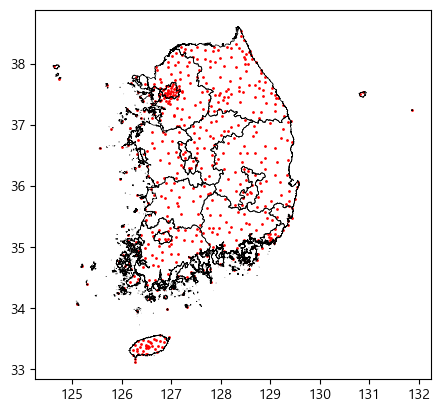

In [14]:
ax = loc_gdf_needed.plot(markersize=1, color= "red")
bdd.boundary.plot(ax = ax, color = "black", linewidth = 0.5)

<Axes: >

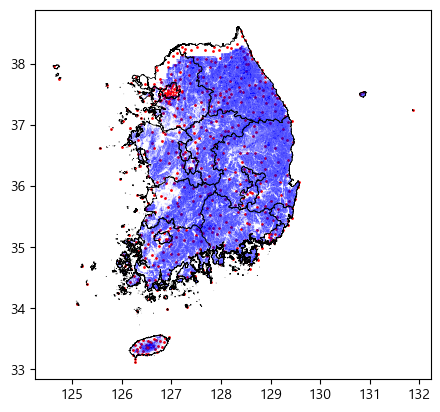

In [15]:
ax = loc_gdf_needed.plot(markersize=1, color= "red")
bdd.boundary.plot(ax = ax, color = "black", linewidth = 0.5)
data.plot(ax = ax, color= "blue", markersize= 0.3)

### Frst마다 nearest 관측 지점 mapping

In [16]:
# frst polygon마다 중심점으로 변환 
centroids = gpd.GeoDataFrame(data[["index", "centroids"]], geometry="centroids", crs=data.crs)
centroids

,index,centroids
0,0,POINT (126.92202 37.44349)
1,1,POINT (126.91649 37.4881)
2,2,POINT (126.9229 37.49214)
3,3,POINT (126.91419 37.45243)
4,4,POINT (126.92328 37.45185)
...,...,...
445510,501718,POINT (127.86934 35.9955)
445511,501719,POINT (127.86485 35.99106)
445512,501720,POINT (127.8712 35.98653)
445513,501721,POINT (127.87439 35.99678)


In [17]:
# 가장 가까운 기상 관측 지점과 매핑 
nearest = gpd.sjoin_nearest(centroids, loc_gdf_needed[["geometry", "지점명"]], how="left", distance_col="distance")
nearest

c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,index,centroids,index_right,지점명,distance
0,0,POINT (126.92202 37.44349),118,관악,0.029679
1,1,POINT (126.91649 37.4881),74,기상청,0.005298
2,2,POINT (126.9229 37.49214),74,기상청,0.005523
3,3,POINT (126.91419 37.45243),81,금천,0.019143
4,4,POINT (126.92328 37.45185),81,금천,0.026817
...,...,...,...,...,...
445510,501718,POINT (127.86934 35.9955),410,대덕,0.125225
445511,501719,POINT (127.86485 35.99106),410,대덕,0.127180
445512,501720,POINT (127.8712 35.98653),410,대덕,0.119488
445513,501721,POINT (127.87439 35.99678),410,대덕,0.121460


In [18]:
# 각 지점으로부터 distance 분포 체크
nearest["distance"].describe()

count    445515.000000
mean          0.073983
std           0.035753
min           0.000174
25%           0.046888
50%           0.071361
75%           0.097850
max           0.219486
Name: distance, dtype: float64

<Axes: xlabel='distance'>

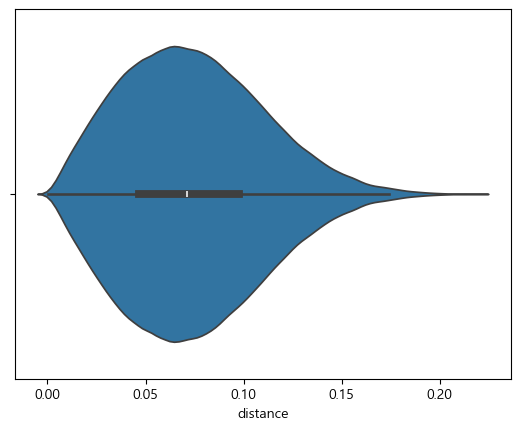

In [19]:
# 평균인 0.07은 대략 7km 정도의 거리 
sns.violinplot(x=nearest["distance"])

### Merging Weather Observing Location with Forest Data

In [20]:
full_data = (data.drop(columns=["centroids"])).merge(nearest.drop(columns=["centroids"]), on = "index", how = "left")
full_data

,index,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,geometry,index_right,지점명,distance
0,0,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92156 37.44277, 126.92144 ...",118,관악,0.029679
1,1,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.91631 37.48976, 126.91672 ...",74,기상청,0.005298
2,2,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92213 37.49274, 126.92385 ...",74,기상청,0.005523
3,3,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.91117 37.45484, 126.91303 ...",81,금천,0.019143
4,4,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.92227 37.45497, 126.92483 ...",81,금천,0.026817
...,...,...,...,...,...,...,...,...,...,...
445510,501718,Q,2,4,C,활엽수림,"MULTIPOLYGON (((127.86824 35.99774, 127.87158 ...",410,대덕,0.125225
445511,501719,Q,2,5,B,활엽수림,"MULTIPOLYGON (((127.8648 35.99199, 127.8671 35...",410,대덕,0.127180
445512,501720,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.87263 35.98754, 127.87137 ...",410,대덕,0.119488
445513,501721,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.875 35.99708, 127.875 35.9...",410,대덕,0.121460


In [21]:
# 각 산림마다 가까운 기상 관측소 매핑.
full_data.to_file("weather_Loc&frs(artif_included).gpkg", driver="GPKG")

#### 산불 데이터 location Merge

## 산불 데이터 전처리

In [22]:
# (이경헌 학우 전처리 코드 이용)
sig_gdf = gpd.read_file("../data/sig_20230729/sig.shp", encoding='euc-kr')
sig_gdf.geometry = sig_gdf.geometry.set_crs('EPSG:5179')
sig_gdf.geometry = sig_gdf.geometry.to_crs('EPSG:4326')

emd_gdf = gpd.read_file("../data/emd_20230729/emd.shp", encoding='euc-kr')
emd_gdf.geometry = emd_gdf.geometry.set_crs('EPSG:5179')
emd_gdf.geometry = emd_gdf.geometry.to_crs('EPSG:4326')

In [23]:
# (이경헌 학우 전처리 코드 이용)
df = pd.read_csv('산불데이터에코드매핑.csv')
df

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법
0,2024,9,29,15:41,일,2024,9,30,16:30,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,전북 남원,전북 남원 산동,45,45190.0,45190410.0,완전 매칭,"시도,시군구,읍면동"
1,2024,9,10,15:55,화,2024,9,10,18:00,경남,경남,밀양,NaN,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,경남 밀양,경남 밀양 내이,48,48270.0,48270102.0,완전 매칭,"시도,시군구,읍면동"
2,2024,9,10,14:35,화,2024,9,10,17:52,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,충남 부여,충남 부여 규암,44,44760.0,44760310.0,완전 매칭,"시도,시군구,읍면동"
3,2024,9,10,14:24,화,2024,9,10,22:00,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,경북 상주,경북 상주 화동,47,47250.0,47250400.0,완전 매칭,"시도,시군구,읍면동"
4,2024,9,5,13:51,목,2024,9,5,16:10,경북,경북,안동,녹전,매정,NaN,기타(직접입력),농산폐기물소각,0.05,녹전,경북 안동,경북 안동 녹전,47,47170.0,47170430.0,완전 매칭,"시도,시군구,읍면동"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,2022,1,3,12:36,월,2022,1,3,15:35,대구,대구,달성,옥포,반송,기,기타(직접입력),화목난로비화,0.08,옥포,대구 달성,대구 달성 옥포,27,27710.0,27710262.0,완전 매칭,"시도,시군구,읍면동"
1566,2022,1,3,12:02,월,2022,1,3,14:56,강원,강원,인제,남,수산,기,기타(직접입력),화목보일러재투기,0.80,남,강원 인제,강원 인제 남,51,51810.0,51810310.0,완전 매칭,"시도,시군구,읍면동"
1567,2022,1,2,14:29,일,2022,1,2,16:50,전남,전남,보성,조성,귀산,담,담뱃불실화,담뱃불실화,0.10,조성,전남 보성,전남 보성 조성,46,46780.0,46780370.0,완전 매칭,"시도,시군구,읍면동"
1568,2022,1,2,08:18,일,2022,1,2,12:50,경북,대구,군위,부계,신화,NaN,주택화재비화,축사전기누전,0.20,부계,대구 군위,대구 군위 부계,27,27720.0,27720330.0,완전 매칭,"시도,시군구,읍면동"


In [24]:
# (이경헌 학우 전처리 코드 이용)
df['SIG_CD'] = df['SIG_CD'].apply(lambda x: f'{x:.0f}')
df['EMD_CD'] = df['EMD_CD'].apply(lambda x: f'{x:.0f}')
df = df[(df['SIG_CD'] != "nan") & (df['EMD_CD'] != "nan")]
sig_rep_pts = dict(zip(sig_gdf['SIG_CD'], sig_gdf.geometry.apply(lambda x: x.representative_point())))
emd_rep_pts = dict(zip(emd_gdf['EMD_CD'], emd_gdf.geometry.apply(lambda x: x.representative_point())))

In [25]:
# (이경헌 학우 전처리 코드 이용)
df['REP_COORD'] = df['EMD_CD'].map(emd_rep_pts)
df.loc[df['REP_COORD'].isna(), 'REP_COORD'] =  df.loc[df['REP_COORD'].isna(), 'SIG_CD'].map(sig_rep_pts)
assert df['REP_COORD'].isna().sum() == 0


C:\Users\sc.lee\AppData\Local\Temp\ipykernel_25856\1407623092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['REP_COORD'] = df['EMD_CD'].map(emd_rep_pts)


##### 산불 데이터 추가 전처리 

In [26]:
fire_gdf = gpd.GeoDataFrame(
    df, geometry= "REP_COORD", crs="EPSG:4326"
)
fire_gdf

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD
0,2024,9,29,15:41,일,2024,9,30,16:30,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,전북 남원,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",POINT (127.48083 35.50199)
1,2024,9,10,15:55,화,2024,9,10,18:00,경남,경남,밀양,NaN,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,경남 밀양,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",POINT (128.74364 35.497)
2,2024,9,10,14:35,화,2024,9,10,17:52,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,충남 부여,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",POINT (126.86571 36.28309)
3,2024,9,10,14:24,화,2024,9,10,22:00,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,경북 상주,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",POINT (127.97244 36.398)
4,2024,9,5,13:51,목,2024,9,5,16:10,경북,경북,안동,녹전,매정,NaN,기타(직접입력),농산폐기물소각,0.05,녹전,경북 안동,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",POINT (128.76731 36.75129)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,2022,1,3,12:36,월,2022,1,3,15:35,대구,대구,달성,옥포,반송,기,기타(직접입력),화목난로비화,0.08,옥포,대구 달성,대구 달성 옥포,27,27710,27710262,완전 매칭,"시도,시군구,읍면동",POINT (128.48786 35.76543)
1566,2022,1,3,12:02,월,2022,1,3,14:56,강원,강원,인제,남,수산,기,기타(직접입력),화목보일러재투기,0.80,남,강원 인제,강원 인제 남,51,51810,51810310,완전 매칭,"시도,시군구,읍면동",POINT (128.10488 37.9979)
1567,2022,1,2,14:29,일,2022,1,2,16:50,전남,전남,보성,조성,귀산,담,담뱃불실화,담뱃불실화,0.10,조성,전남 보성,전남 보성 조성,46,46780,46780370,완전 매칭,"시도,시군구,읍면동",POINT (127.24196 34.80107)
1568,2022,1,2,08:18,일,2022,1,2,12:50,경북,대구,군위,부계,신화,NaN,주택화재비화,축사전기누전,0.20,부계,대구 군위,대구 군위 부계,27,27720,27720330,완전 매칭,"시도,시군구,읍면동",POINT (128.6619 36.06617)


<Axes: >

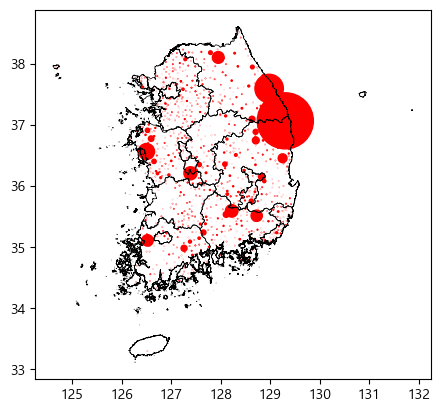

In [27]:
fir = fire_gdf.plot(markersize = fire_gdf.피해면적_합계/10, color = "red")
bdd.boundary.plot(ax = fir, color = "black", linewidth = 0.5)

In [28]:
# 추가로 이상값 발견 1
# 진화 종료 년도 입력 오류 
fire_gdf.loc[227]

발생일시_년                                                     2023
발생일시_월                                                       12
발생일시_일                                                       27
발생일시_시간                                                   14:57
발생일시_요일                                                       수
진화종료시간_년                                                   2223
진화종료시간_월                                                     12
진화종료시간_일                                                     27
진화종료시간_시간                                                 18:00
발생장소_관서                                                      경남
발생장소_시도                                                      경남
발생장소_시군구                                                     밀양
발생장소_읍면                                                     삼랑진
발생장소_동리                                                      행곡
발생원인_구분                                                     NaN
발생원인_세부원인                               

In [29]:
# 추가로 이상값 발견 2
# 진화 종료 시간 오류 입력
fire_gdf.loc[[998, 717, 968, 969, 999, 1159, 1271, 1286, 1339, 1417, 1516]]

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD
998,2022,5,22,22:54,일,2022,5,22,00:00,부산,부산,사상,NaN,괘법,기,기타(직접입력),조사중,0.02,괘법,부산 사상,부산 사상 괘법,26,26530,26530104,완전 매칭,"시도,시군구,읍면동",POINT (128.99179 35.16677)
717,2023,2,24,14:20,금,2023,2,24,00:00,부산,부산,기장,정관,병산,담,기타(직접입력),담뱃불실화,3.00,정관,부산 기장,부산 기장 정관,26,26710,26710256,완전 매칭,"시도,시군구,읍면동",POINT (129.17156 35.34029)
968,2022,5,29,22:25,일,2022,5,29,00:00,경남,경남,거제,하청,덕곡,기,기타(직접입력),아궁아불씨부주의,0.20,하청,경남 거제,경남 거제 하청,48,48310,48310380,완전 매칭,"시도,시군구,읍면동",POINT (128.63588 34.95725)
969,2022,5,29,22:15,일,2022,5,29,00:00,전북,전북,진안,마령,계서,기,기타(직접입력),화목보일러추정,0.20,마령,전북 진안,전북 진안 마령,45,45720,45720370,완전 매칭,"시도,시군구,읍면동",POINT (127.36998 35.74056)
999,2022,5,22,18:28,일,2022,5,22,00:00,남부,경남,김해,NaN,구산,입,기타(직접입력),입산자실화추정,1.00,구산,경남 김해,경남 김해 구산,48,48250,48250106,완전 매칭,"시도,시군구,읍면동",POINT (128.87469 35.24966)
1159,2022,4,11,18:34,월,2022,4,11,00:00,울산,울산,울주,두서,내와,NaN,주택화재비화,주택화재비화,0.50,두서,울산 울주,울산 울주 두서,31,31710,31710370,완전 매칭,"시도,시군구,읍면동",POINT (129.14437 35.66717)
1271,2022,3,12,14:09,토,2022,3,12,00:00,북부,강원,홍천,서석,생곡,쓰,쓰레기소각,생활쓰레기소각,8.00,서석,강원 홍천,강원 홍천 서석,51,51720,51720340,완전 매칭,"시도,시군구,읍면동",POINT (128.2201 37.7278)
1286,2022,3,9,20:07,수,2022,3,9,00:00,울산,울산,북,NaN,천곡,기,기타(직접입력),미상,1.00,천곡,울산 북,울산 북 천곡,31,31200,31200108,완전 매칭,"시도,시군구,읍면동",POINT (129.32233 35.64934)
1339,2022,2,28,20:18,월,2022,2,28,00:00,경북,경북,안동,NaN,정상,입,기타(직접입력),입산자실화,0.67,정상,경북 안동,경북 안동 정상,47,47170,47170139,완전 매칭,"시도,시군구,읍면동",POINT (128.75268 36.54334)
1417,2022,2,18,19:34,금,2022,2,18,00:00,전남,전남,여수,NaN,오림,입,기타(직접입력),입산자실화,0.30,오림,전남 여수,전남 여수 오림,46,46130,46130121,완전 매칭,"시도,시군구,읍면동",POINT (127.7168 34.75915)


In [30]:
# 이상값 처리 
fire_gdf.loc[227, "진화종료시간_년"] = 2023
fire_gdf.loc[[998, 717, 968, 969, 999, 1159, 1271, 1286, 1339, 1417, 1516], "진화종료시간_시간"] = "23:59"

In [31]:
fire_gdf.loc[[998, 717, 968, 969, 999, 1159, 1271, 1286, 1339, 1417, 1516]]

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD
998,2022,5,22,22:54,일,2022,5,22,23:59,부산,부산,사상,NaN,괘법,기,기타(직접입력),조사중,0.02,괘법,부산 사상,부산 사상 괘법,26,26530,26530104,완전 매칭,"시도,시군구,읍면동",POINT (128.99179 35.16677)
717,2023,2,24,14:20,금,2023,2,24,23:59,부산,부산,기장,정관,병산,담,기타(직접입력),담뱃불실화,3.00,정관,부산 기장,부산 기장 정관,26,26710,26710256,완전 매칭,"시도,시군구,읍면동",POINT (129.17156 35.34029)
968,2022,5,29,22:25,일,2022,5,29,23:59,경남,경남,거제,하청,덕곡,기,기타(직접입력),아궁아불씨부주의,0.20,하청,경남 거제,경남 거제 하청,48,48310,48310380,완전 매칭,"시도,시군구,읍면동",POINT (128.63588 34.95725)
969,2022,5,29,22:15,일,2022,5,29,23:59,전북,전북,진안,마령,계서,기,기타(직접입력),화목보일러추정,0.20,마령,전북 진안,전북 진안 마령,45,45720,45720370,완전 매칭,"시도,시군구,읍면동",POINT (127.36998 35.74056)
999,2022,5,22,18:28,일,2022,5,22,23:59,남부,경남,김해,NaN,구산,입,기타(직접입력),입산자실화추정,1.00,구산,경남 김해,경남 김해 구산,48,48250,48250106,완전 매칭,"시도,시군구,읍면동",POINT (128.87469 35.24966)
1159,2022,4,11,18:34,월,2022,4,11,23:59,울산,울산,울주,두서,내와,NaN,주택화재비화,주택화재비화,0.50,두서,울산 울주,울산 울주 두서,31,31710,31710370,완전 매칭,"시도,시군구,읍면동",POINT (129.14437 35.66717)
1271,2022,3,12,14:09,토,2022,3,12,23:59,북부,강원,홍천,서석,생곡,쓰,쓰레기소각,생활쓰레기소각,8.00,서석,강원 홍천,강원 홍천 서석,51,51720,51720340,완전 매칭,"시도,시군구,읍면동",POINT (128.2201 37.7278)
1286,2022,3,9,20:07,수,2022,3,9,23:59,울산,울산,북,NaN,천곡,기,기타(직접입력),미상,1.00,천곡,울산 북,울산 북 천곡,31,31200,31200108,완전 매칭,"시도,시군구,읍면동",POINT (129.32233 35.64934)
1339,2022,2,28,20:18,월,2022,2,28,23:59,경북,경북,안동,NaN,정상,입,기타(직접입력),입산자실화,0.67,정상,경북 안동,경북 안동 정상,47,47170,47170139,완전 매칭,"시도,시군구,읍면동",POINT (128.75268 36.54334)
1417,2022,2,18,19:34,금,2022,2,18,23:59,전남,전남,여수,NaN,오림,입,기타(직접입력),입산자실화,0.30,오림,전남 여수,전남 여수 오림,46,46130,46130121,완전 매칭,"시도,시군구,읍면동",POINT (127.7168 34.75915)


In [32]:
#['발생일시_년', '발생일시_월', '발생일시_일', '발생일시_시간']
fire_gdf["발생일시"] = pd.to_datetime(
    fire_gdf["발생일시_년"].astype(str) + "-" +
    fire_gdf["발생일시_월"].astype(str).str.zfill(2) + "-" +
    fire_gdf["발생일시_일"].astype(str).str.zfill(2) + " " +
    fire_gdf["발생일시_시간"]
)

fire_gdf["진화일시"] = pd.to_datetime(
    fire_gdf["진화종료시간_년"].astype(str) + "-" +
    fire_gdf["진화종료시간_월"].astype(str).str.zfill(2) + "-" +
    fire_gdf["진화종료시간_일"].astype(str).str.zfill(2) + " " +
    fire_gdf["진화종료시간_시간"]
)

fire_gdf.drop(columns=['발생일시_년', '발생일시_월', '발생일시_일', '발생일시_시간','발생일시_요일', '진화종료시간_년','진화종료시간_월', '진화종료시간_일', '진화종료시간_시간'], inplace= True)
fire_gdf["duration"] = (fire_gdf.진화일시 - fire_gdf.발생일시).dt.total_seconds() / 3600

In [33]:
fire_gdf.head()

,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD,발생일시,진화일시,duration
0,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,전북 남원,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",POINT (127.48083 35.50199),2024-09-29 15:41:00,2024-09-30 16:30:00,24.816667
1,경남,경남,밀양,NaN,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,경남 밀양,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",POINT (128.74364 35.497),2024-09-10 15:55:00,2024-09-10 18:00:00,2.083333
2,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,충남 부여,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",POINT (126.86571 36.28309),2024-09-10 14:35:00,2024-09-10 17:52:00,3.283333
3,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,경북 상주,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",POINT (127.97244 36.398),2024-09-10 14:24:00,2024-09-10 22:00:00,7.600000
4,경북,경북,안동,녹전,매정,NaN,기타(직접입력),농산폐기물소각,0.05,녹전,경북 안동,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",POINT (128.76731 36.75129),2024-09-05 13:51:00,2024-09-05 16:10:00,2.316667


In [34]:
fire_gdf.index[fire_gdf.duration<0]

Index([], dtype='int64')

<Axes: xlabel='duration', ylabel='피해면적_합계'>

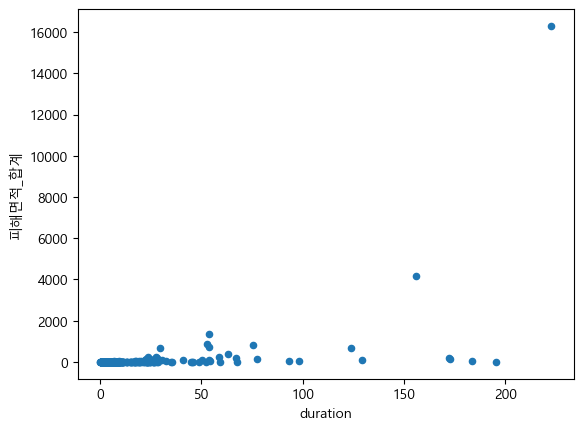

In [35]:
fire_gdf.plot.scatter(x = "duration", y="피해면적_합계")

In [36]:
fire_gdf[fire_gdf.duration>150]

,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD,발생일시,진화일시,duration
1226,경북,경북,봉화,봉화,화천,기,기타(직접입력),화목보일러재투기,130.00,봉화,경북 봉화,경북 봉화 봉화,47,47920,47920250,완전 매칭,"시도,시군구,읍면동",POINT (128.70331 36.88937),2022-04-05 13:29:00,2022-04-12 18:00:00,172.516667
1308,대구,대구,달성,가창,오,기,기타(직접입력),산불비화추정,22.96,가창,대구 달성,대구 달성 가창,27,27710,27710310,완전 매칭,"시도,시군구,읍면동",POINT (128.61725 35.75567),2022-03-05 19:15:00,2022-03-13 11:00:00,183.750000
1318,강원,강원,강릉,옥계,남양,기,방화,방화,4190.38,옥계,강원 강릉,강원 강릉 옥계,51,51150,51150350,완전 매칭,"시도,시군구,읍면동",POINT (128.9765 37.59884),2022-03-05 01:08:00,2022-03-11 13:00:00,155.866667
1325,강원,강원,영월,김삿갓,외룡,기,기타(직접입력),화목보일러불씨,184.01,김삿갓,강원 영월,강원 영월 김삿갓,51,51750,51750325,완전 매칭,"시도,시군구,읍면동",POINT (128.63086 37.09619),2022-03-04 12:45:00,2022-03-11 17:00:00,172.250000
1326,경북,경북,울진,북,두천,기,기타(직접입력),도로변발화추정,16301.98,북,경북 울진,경북 울진 북,47,47930,47930310,완전 매칭,"시도,시군구,읍면동",POINT (129.30298 37.06908),2022-03-04 11:17:00,2022-03-13 18:00:00,222.716667
1336,남부,부산,금정,NaN,회동,기,기타(직접입력),미상,20.00,회동,부산 금정,부산 금정 회동,26,26410,26410112,완전 매칭,"시도,시군구,읍면동",POINT (129.12794 35.23911),2022-03-02 14:43:00,2022-03-10 18:00:00,195.283333


# 산불 발생 지점과 기상관측 지점 매핑

In [37]:
# 산불 발생 지점과 가장 가까운 기상 관측 지점 매핑 
fire_nearest = gpd.sjoin_nearest(fire_gdf, loc_gdf_needed[["geometry", "지점명"]], how="left", distance_col="distance")
fire_nearest.head()

c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD,발생일시,진화일시,duration,index_right,지점명,distance
0,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,전북 남원,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",POINT (127.48083 35.50199),2024-09-29 15:41:00,2024-09-30 16:30:00,24.816667,63,번암,0.075951
1,경남,경남,밀양,NaN,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,경남 밀양,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",POINT (128.74364 35.497),2024-09-10 15:55:00,2024-09-10 18:00:00,2.083333,522,생림,0.146043
2,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,충남 부여,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",POINT (126.86571 36.28309),2024-09-10 14:35:00,2024-09-10 17:52:00,3.283333,296,정산,0.137384
3,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,경북 상주,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",POINT (127.97244 36.398),2024-09-10 14:24:00,2024-09-10 22:00:00,7.600000,435,화서,0.051610
4,경북,경북,안동,녹전,매정,NaN,기타(직접입력),농산폐기물소각,0.05,녹전,경북 안동,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",POINT (128.76731 36.75129),2024-09-05 13:51:00,2024-09-05 16:10:00,2.316667,438,이산,0.145530


In [38]:
fire_nearest.to_file("fire_clean.gpkg", driver="GPKG")

In [39]:
# 발생일시 넣으면 나오는 그날 시간 함수..?
def Hours_before_fire(x,H):
    li = []
    x = pd.to_datetime(x)
    start = x.replace(minute=0, second=0, microsecond=0)
    for i in range(H):
        li.append(start - timedelta.Timedelta(hours=i))
    return li